In [8]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('house.csv', encoding='gbk')
df.head()

,户型,建筑面积,朝向,楼层,装修,建筑年代,电梯,产权性质,住宅类别,建筑结构,建筑类别,区域,学校,总价,单价
0,2室2厅1卫,104.66平米,南,高层,毛坯,2020年,有,商品房,普通住宅,平层,板楼,城关,0,191.0,18250元/平米
1,1室1厅1卫,48.86平米,南北,中层,简装修,2020年,无,商品房,普通住宅,平层,板楼,城关,1,63.0,12894元/平米
2,1室3厅1卫,80平米,南北,低层,简装修,NaN,无,房改房,NaN,平层,NaN,城关,0,118.0,14750元/平米
3,3室2厅2卫,118.00平米,南北,中楼层,暂无,NaN,NaN,NaN,NaN,NaN,NaN,安宁,0,142.0,12034元/平米
4,3室2厅1卫,94.66平米,南,中层,毛坯,2015年,有,个人产权,普通住宅,平层,板楼,安宁,0,110.0,11621元/平米


In [10]:
# 重复项
df.duplicated().sum()

2329

In [11]:
# 缺失值
df.isna().sum()

户型         0
建筑面积       0
朝向         0
楼层         0
装修         0
建筑年代    2081
电梯      1859
产权性质    1859
住宅类别    2825
建筑结构    3862
建筑类别    2496
区域         0
学校         0
总价         0
单价         0
dtype: int64

In [12]:
df.replace('暂无',np.nan,inplace=True)
df['建筑面积'] = df['建筑面积'].map(lambda x: x.replace('平米','')).astype('float')
df['单价'] = df['单价'].map(lambda x: x.replace('元/平米','')).astype('float')
def process_year(year):
    if year is not None:
        year = str(year)[:4]
    return year   
df['建筑年代'] = df['建筑年代'].map(process_year)
floor = {'低楼层': '低','中楼层': '中','高楼层': '高','低层': '低','中层': '中','高层': '高'}
df['楼层'] = df['楼层'].map(floor)
def process_area(area):
    if area != '新区':
        area = area.replace('区','').replace('县','')
    return area   
df['区域'] = df['区域'].map(process_area)
df.replace('nan',np.nan,inplace=True)

In [13]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,户型,建筑面积,朝向,楼层,装修,建筑年代,电梯,产权性质,住宅类别,建筑结构,建筑类别,区域,学校,总价,单价
0,2室2厅1卫,104.66,南,高,毛坯,2020,有,商品房,普通住宅,平层,板楼,城关,0,191.0,18250.0
1,1室1厅1卫,48.86,南北,中,简装修,2020,无,商品房,普通住宅,平层,板楼,城关,1,63.0,12894.0
2,1室3厅1卫,80.00,南北,低,简装修,NaN,无,房改房,NaN,平层,NaN,城关,0,118.0,14750.0
3,3室2厅2卫,118.00,南北,中,NaN,NaN,NaN,NaN,NaN,NaN,NaN,安宁,0,142.0,12034.0
4,3室2厅1卫,94.66,南,中,毛坯,2015,有,个人产权,普通住宅,平层,板楼,安宁,0,110.0,11621.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6608 entries, 0 to 6607
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   户型      6597 non-null   object 
 1   建筑面积    6608 non-null   float64
 2   朝向      6601 non-null   object 
 3   楼层      6603 non-null   object 
 4   装修      5202 non-null   object 
 5   建筑年代    5138 non-null   object 
 6   电梯      5307 non-null   object 
 7   产权性质    5307 non-null   object 
 8   住宅类别    4619 non-null   object 
 9   建筑结构    3840 non-null   object 
 10  建筑类别    4829 non-null   object 
 11  区域      6608 non-null   object 
 12  学校      6608 non-null   int64  
 13  总价      6608 non-null   float64
 14  单价      6608 non-null   float64
dtypes: float64(3), int64(1), object(11)
memory usage: 774.5+ KB


In [16]:
df.dropna(subset=['户型', '朝向', '楼层'])
df.loc[(df['楼层'] == '高') & (df['电梯'].isnull()), '电梯'] = '有'
df.loc[(df['楼层'] == '低') & (df['电梯'].isnull()), '电梯'] = '无'
df.loc[(df['楼层'] == '中') & (df['电梯'].isnull()), '电梯'] = random.choice(['有', '无'])
df.reset_index(drop=True, inplace=True)
df.head()

,户型,建筑面积,朝向,楼层,装修,建筑年代,电梯,产权性质,住宅类别,建筑结构,建筑类别,区域,学校,总价,单价
0,2室2厅1卫,104.66,南,高,毛坯,2020,有,商品房,普通住宅,平层,板楼,城关,0,191.0,18250.0
1,1室1厅1卫,48.86,南北,中,简装修,2020,无,商品房,普通住宅,平层,板楼,城关,1,63.0,12894.0
2,1室3厅1卫,80.00,南北,低,简装修,NaN,无,房改房,NaN,平层,NaN,城关,0,118.0,14750.0
3,3室2厅2卫,118.00,南北,中,NaN,NaN,无,NaN,NaN,NaN,NaN,安宁,0,142.0,12034.0
4,3室2厅1卫,94.66,南,中,毛坯,2015,有,个人产权,普通住宅,平层,板楼,安宁,0,110.0,11621.0


<AxesSubplot:>

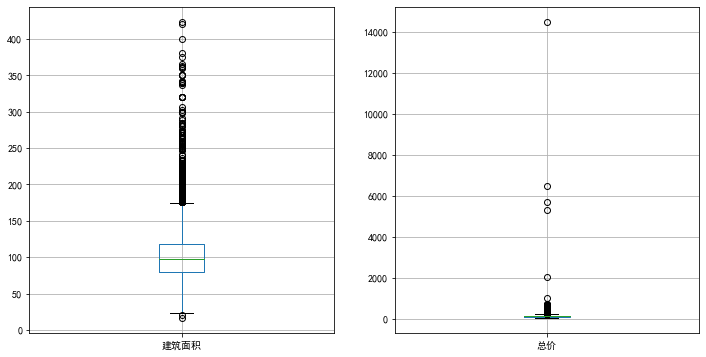

In [24]:
# 箱线图分析
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(1, 2, figsize=(12,6))
df.boxplot(column=['建筑面积'], ax=ax[0])
df.boxplot(column=['总价'], ax=ax[1])

In [25]:
# 将高于房价200万的删除
df.drop(index = df[df['总价'] > 200].index, inplace=True)

In [26]:
# 另存为新文件
df.to_excel('house.xlsx',encoding='utf8',index=False)

<AxesSubplot:ylabel='总价'>

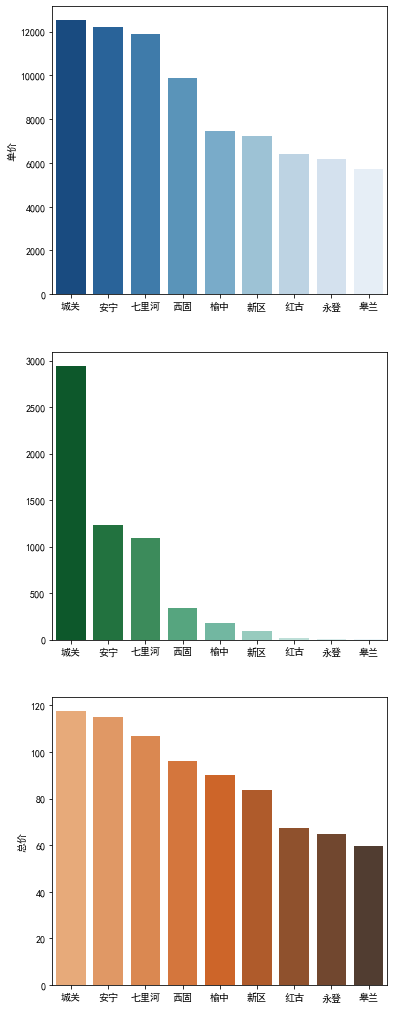

In [32]:
# 探究单价、数量、总价和行政区域之间的关系
fig, ax = plt.subplots(3,1, figsize=(6, 18))
x = df['区域'].unique()
y1 = df.groupby(['区域'])['单价'].mean().sort_values(ascending=False)
sns.barplot(x, y1, ax=ax[0], palette='Blues_r')
y2 = df.groupby(['区域']).size().sort_values(ascending=False)
sns.barplot(x, y2, ax=ax[1], palette='BuGn_r')
y3 = df.groupby(['区域'])['总价'].mean().sort_values(ascending=False)
sns.barplot(x, y3, ax=ax[2], palette='Oranges_d')

<AxesSubplot:xlabel='建筑面积', ylabel='总价'>

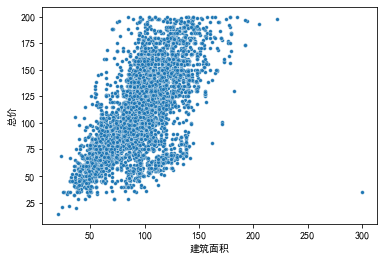

In [37]:
# plt.figure(figsize=(8,8))
sns.scatterplot(x='建筑面积', y='总价', data=df, s=14)

<AxesSubplot:xlabel='朝向', ylabel='总价'>

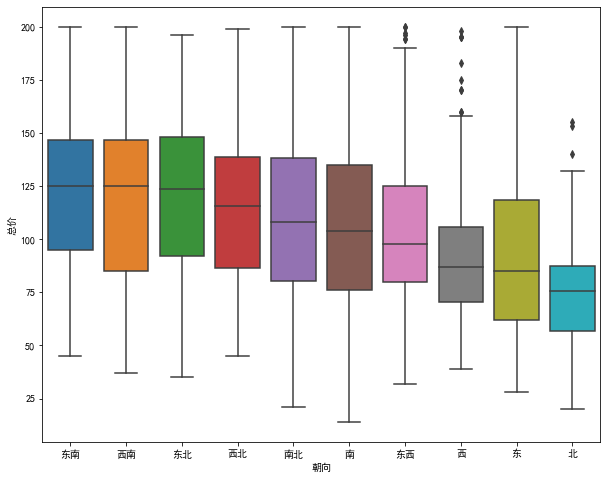

In [40]:
plt.figure(figsize=(10, 8))
order = df.groupby(['朝向'])['总价'].median().sort_values(ascending=False).index
sns.boxplot(x='朝向', y='总价', data=df, order=order)

<AxesSubplot:xlabel='建筑年代', ylabel='count'>

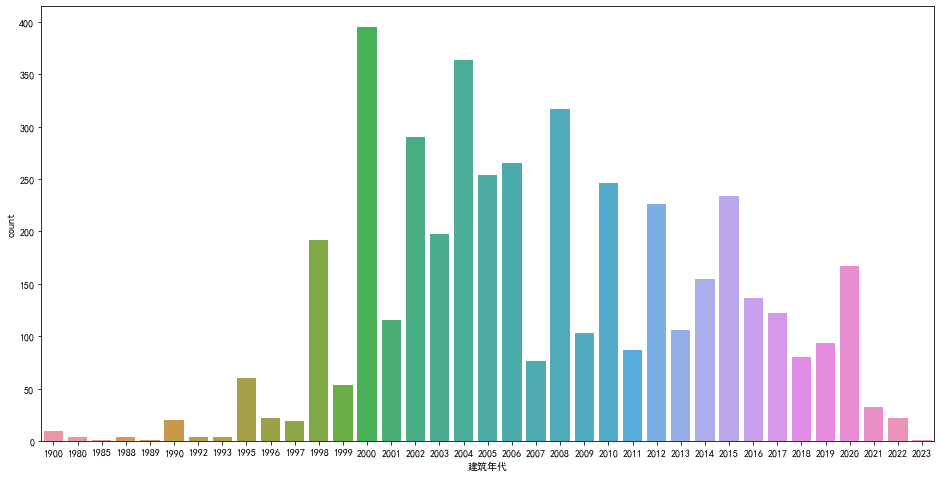

In [43]:
plt.figure(figsize=(16,8))
order = sorted(df['建筑年代'].value_counts().index)
sns.countplot(x=df['建筑年代'],order=order)

In [44]:
# 删除所有缺失值
d1 = df.dropna().reset_index(drop=True)
# 分解户型
def apart_room(x):
    room = x.split('室')[0]
    return int(room)
def apart_hall(x):
    hall = x.split('厅')[0].split('室')[1]
    return int(hall)
def apart_wc(x):
    wc = x.split('卫')[0].split('厅')[1]
    return int(wc)
d1['室'] = d1['户型'].map(apart_room)
d1['厅'] = d1['户型'].map(apart_hall)
d1['卫'] = d1['户型'].map(apart_wc)
# 删除楼层、户型、单价
d1.drop(columns=['户型','楼层','单价'],inplace=True)
# 编码-有序多分类（根据上面可视化的结果，按照对价格的影响程度排序，越大影响越高）
# 无序多分类无法直接引入，必须“哑元”化变量
# 等级变量（有序多分类）可以直接引入模型
map1 = {'南':5, '南北':6, '北':1, '西南':10, '东西':4, '东':2, '东北':8, '东南':9, '西':3, '西北':7}
d1['朝向'] = d1['朝向'].map(map1)
map2 = {'毛坯':1, '简装修':2, '精装修':3, '中装修':4, '豪华装修':5}
d1['装修'] = d1['装修'].map(map2)
map3 = {'有 ':1, '无 ':0}
d1['电梯'] = d1['电梯'].map(map3)
map4 = {'商品房':6, '个人产权':5, '商品房(免税)':7, '普通商品房':4, '经济适用房':2, '房改房':3, '限价房':8, '房本房':1}
d1['产权性质'] = d1['产权性质'].map(map4)
map5 = {'普通住宅':4, '经济适用房':3, '公寓':1, '商住楼':2, '酒店式公寓':5}
d1['住宅类别'] = d1['住宅类别'].map(map5)
map6 = {'平层':4, '开间':2, '跃层':5, '错层':1, '复式':3}
d1['建筑结构'] = d1['建筑结构'].map(map6)
map7 = {'板楼':4, '钢混':5, '塔板结合':3, '平房':6, '砖混':1, '塔楼':7, '砖楼':2}
d1['建筑类别'] = d1['建筑类别'].map(map7)
map8 = {'城关':6, '安宁':5, '七里河':4, '西固':3,'榆中':2, '永登':1}
d1['区域'] = d1['区域'].map(map8)
# 删除超过2019年的房子，年代转变为房龄
d1['建筑年代'] = d1['建筑年代'].astype('int32')
d1.drop(index=d1[d1['建筑年代']>2019].index,inplace=True)
d1['房龄'] = d1['建筑年代'].map(lambda x: 2020-x)
d1.drop(columns=['建筑年代'],inplace=True)

In [46]:
X = d1.drop(columns=['总价'])
y = d1['总价']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=33)
poly = PolynomialFeatures(degree=2)
x_train = poly.fit_transform(X_train)
x_test = poly.fit_transform(X_test)

In [48]:
x_train.shape

(1938, 120)

In [49]:
# 套索回归
la = Lasso(alpha=0.1,max_iter=100000)
la.fit(x_train,y_train)
print(f'训练集得分：{round(la.score(x_train,y_train),2)}')
print(f'测试集得分：{round(la.score(x_test,y_test),2)}')

训练集得分：0.71
测试集得分：0.71


In [50]:
# 随机森林
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
print(f'训练集得分：{round(rf.score(x_train,y_train),2)}')
print(f'测试集得分：{round(rf.score(x_test,y_test),2)}')

训练集得分：0.96
测试集得分：0.77


In [51]:
dt = DecisionTreeRegressor(max_depth = 6)
dt.fit(x_train,y_train)
print(f'训练集得分：{round(dt.score(x_train,y_train),2)}')
print(f'测试集得分：{round(dt.score(x_test,y_test),2)}')

训练集得分：0.76
测试集得分：0.71


In [52]:
# k近邻

kn = KNeighborsRegressor(n_neighbors=20)
kn.fit(x_train,y_train)
print(f'训练集得分：{round(kn.score(x_train,y_train),2)}')
print(f'测试集得分：{round(kn.score(x_test,y_test),2)}')

训练集得分：0.7
测试集得分：0.7


In [53]:
apply = np.array([95,10,4,0,5,4,4,5,6,1,3,1,1,10]).reshape(1,-1)
poly_apply = poly.fit_transform(apply)
print('------------总价预测结果-------------')
print(f'线性回归：{round(la.predict(poly_apply)[0],2)}万元')
print(f'随机森林回归：{round(rf.predict(poly_apply)[0],2)}万元')
print(f'决策树回归：{round(dt.predict(poly_apply)[0],2)}万元')
print(f'K近邻回归：{round(kn.predict(poly_apply)[0],2)}万元')
print('------------综合预测结果-------------')
print(round(((la.predict(poly_apply)+rf.predict(poly_apply)+dt.predict(poly_apply)+kn.predict(poly_apply))/4.0)[0],2),'万元')

------------总价预测结果-------------
线性回归：135.15万元
随机森林回归：152.41万元
决策树回归：133.37万元
K近邻回归：135.24万元
------------综合预测结果-------------
139.04 万元


In [54]:
la.predict(poly_apply)

array([135.14581035])